# Wstęp
Dostępne dane dotyczące kardiotoksyczności są w trzech różnych plikach (dla każdego rodzaju fingerprintów osobny).
Struktura każdego z nich jest jednak bardzo podobna, więc zamiast powtarzać podobny kod kilka razy napisałem funkcje 'fingerprints_analysis' w której przeprowadzam ogólną analize, a następnie wywołuje ją dla każdego z plików osobno. W pierwszej części notebooka znajdują się funkcje z których korzystam, w drugiej wywołanie funkcji oraz wynikowa analiza, w trzeciej wnioski z przeprowadzonej analizy.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import utils

In [2]:
def display_full(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('display.max_rows')

In [3]:
def print_percent_of_occurrances(df, size, min_perc):
    min_occurrs = int(size * min_perc)
    qualified = df[df['number_of_feature_occurrences']<=min_occurrs].shape[0]
    perc = (qualified / df.shape[0]) * 100
    
    if min_perc == 0:
        print(f'{round(perc, 2)}% cech nie występuje w żadnym ze związków.')
    else:
        print(f'{round(perc, 2)}% cech występuje w mniej niż {min_perc*100}% wszystkich związków.')

In [4]:
def print_target_thresholds(target, thresholds):
    for threshold in thresholds:
        target_size = target.shape[0]
        toxic_size = target[target>=threshold].shape[0]
        
        data = [target_size - toxic_size, toxic_size]
        labels = ['Związki nie wykazujące toksyczności', 'Związki toksyczne']

        plt.figure(figsize=(6,6))
        plt.pie(data, labels = labels,
                autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(data)/100),
                wedgeprops = {"edgecolor" : "black",
                              'linewidth': 1})
        
        print(f'Procent związków kardiotoksycznych dla progu IC50 o wartości: {threshold}')
        plt.show()

In [5]:
def target_analysis(df):
        df['IC50'] = pd.to_numeric(df['IC50'], errors='coerce')
        df = df.dropna()
        target = pd.DataFrame(df['IC50'])
        target.columns = ['IC50']
        
        print('Zobaczmy jeszcze jak wyglądają wartości w kolumnie IC50 (nasz target). Z wcześniejszej analizy widzmy, że kolumna IC50 jest identyczna we wszystkich plikach, więc nie powtarzałem już tego kroku dla każdego z plików osobno.')
        display(target.describe().apply(lambda s: s.apply('{0:.5f}'.format)))
        target = df['IC50']
        print()
        print('Zobaczmy jak wartości IC50 rozkładają się na histogramie')
        sns.histplot(data=target[target<1e5], bins=30);
        plt.show()

        print(f'Liczba wartości IC50 mniejszych niż 1: {target[target<=1].shape[0]}')
        print(f'Liczba wartości IC50 większych niż 100 000: {target[target>100_000].shape[0]}')
        print()

        print('Na koniec zobaczmy ile związków zostałoby zaklasyfikowane jako toksyczne w zależności od wartości progu IC50 jaki ustawimy.')
        print()
        thresholds = [10,100,1000,10_000,100_000]
        print_target_thresholds(target, thresholds)

In [6]:
def fingerprints_analysis(df):
    print('Wejściowe dane:')
    display(df)
    print()
    
    print(f'Mamy {df.shape[0]} wierszy oraz {df.shape[1]} kolumn.')
    print('Wszystkie dane są kodowane jako wartości binarne, zapisane jako int64. Jedynie wartość którą przewidujemy - IC50 jest w formacie object.')
    print()
    
    print(f'Ilość wartości nullowych w całym pliku: {df.isnull().sum().sum()}')
    print('Dane binarne są prawidołe, jednak wartości IC50 w niektórych przypadkach są niewłaściwe.')
    print()
    
    fixed_IC50 = pd.to_numeric(df['IC50'], errors='coerce')
    print('Przykładowe niepoprawne wartości:')
    display(df['IC50'][fixed_IC50.isna()])
    wrong = df['IC50'][fixed_IC50.isna()].shape[0]
    print(f'W całym pliku mamy {wrong} niepoprawnych wartości, co stanowi {round((wrong / df.shape[0]) * 100, 2)}% z wszystkich wartości.')
    print()
    
    df['IC50'] = pd.to_numeric(df['IC50'], errors='coerce')
    df = df.dropna()
    print(f'Po usunięciu nieprawidłowych wartości mamy {df.shape[0]} wierszy oraz {df.shape[1]} kolumn.')
    print()
    
    target = df['IC50']
    data = df.drop('IC50',axis=1)
    
    print('Każda z kolumn koduje występowanie danej cechy w związku. Zobaczmy w ilu związkach występują poszczególne cechy. (Ponieważ kodowanych cech jest bardzo dużo, skupiłem się na ogólnych statystykach, a nie poszczególnych wartościach.)')
    occur = pd.DataFrame(data.sum())
    occur.columns = ['number_of_feature_occurrences']
    display(occur)
    print()
    
    print('Suma wystąpień wszystkich cech we wszystkich związkach:', occur.sum()[0])
    display(occur.describe())
    print()
    
    print('Histogram przedstawiający w ilu związkach występuje dana cecha:')
    sns.histplot(data=occur, x='number_of_feature_occurrences', bins=30);
    plt.show()
    
    print_percent_of_occurrances(occur, data.shape[0], 0)
    print_percent_of_occurrances(occur, data.shape[0], 0.001)
    print_percent_of_occurrances(occur, data.shape[0], 0.01)
    print_percent_of_occurrances(occur, data.shape[0], 0.1)
    print_percent_of_occurrances(occur, data.shape[0], 0.5)
    print('\n\n\n')
    
    

In [7]:
cardiotoxicity_files = ['ready_sets/cardiotoxicity_hERG_ExtFP.csv', 'ready_sets/cardiotoxicity_hERG_KlekFP.csv',
                        'ready_sets/cardiotoxicity_hERG_MACCSFP.csv']

W przypadku wszystkich plików w pierwszej kolumnie mamy wartość IC50 która ma związek z kardiotoksycznością. Jest to wartość ciągła, którą będziemy przewidywać. Pozostałe kolumny to fingerprinty które w zależności od typu kodują nieco inne informacje. W ogólności jednak są to wartości binarne informujące czy związke ma daną cechę.

Analiza 1 pliku z fingerprintami (ready_sets/cardiotoxicity_hERG_ExtFP.csv)
Wejściowe dane:


,IC50,ExtFP1,ExtFP2,ExtFP3,ExtFP4,ExtFP5,ExtFP6,ExtFP7,ExtFP8,ExtFP9,...,ExtFP1015,ExtFP1016,ExtFP1017,ExtFP1018,ExtFP1019,ExtFP1020,ExtFP1021,ExtFP1022,ExtFP1023,ExtFP1024
0,645.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,6600.0,0,0,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
2,1600.0,1,0,1,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,6700.0,0,0,1,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,6600.0,0,0,1,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11499,6600.0,0,0,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
11500,100000.0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11501,30000.0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11502,26000.0,1,1,1,1,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0



Mamy 11504 wierszy oraz 1025 kolumn.
Wszystkie dane są kodowane jako wartości binarne, zapisane jako int64. Jedynie wartość którą przewidujemy - IC50 jest w formacie object.

Ilość wartości nullowych w całym pliku: 0
Dane binarne są prawidołe, jednak wartości IC50 w niektórych przypadkach są niewłaściwe.

Przykładowe niepoprawne wartości:


15                   '='
16                   '='
29                   '='
30       27}]TRIACONTA-8
43                   '='
              ...       
11421                '='
11454                '='
11480                '='
11482                '>'
11483                '>'
Name: IC50, Length: 869, dtype: object

W całym pliku mamy 869 niepoprawnych wartości, co stanowi 7.55% z wszystkich wartości.

Po usunięciu nieprawidłowych wartości mamy 10635 wierszy oraz 1025 kolumn.

Każda z kolumn koduje występowanie danej cechy w związku. Zobaczmy w ilu związkach występują poszczególne cechy. (Ponieważ kodowanych cech jest bardzo dużo, skupiłem się na ogólnych statystykach, a nie poszczególnych wartościach.)


,number_of_feature_occurrences
ExtFP1,3575
ExtFP2,4025
ExtFP3,4459
ExtFP4,5844
ExtFP5,2045
...,...
ExtFP1020,1
ExtFP1021,0
ExtFP1022,0
ExtFP1023,0



Suma wystąpień wszystkich cech we wszystkich związkach: 4425950


,number_of_feature_occurrences
count,1024.000000
mean,4322.216797
std,2274.893459
min,0.000000
25%,2724.750000
50%,3791.000000
75%,5381.000000
max,10635.000000



Histogram przedstawiający w ilu związkach występuje dana cecha:


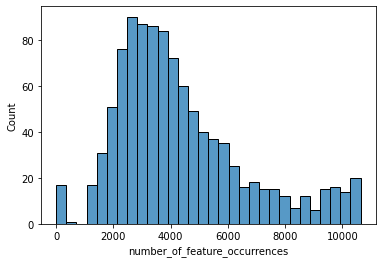

1.37% cech nie występuje w żadnym ze związków.
1.56% cech występuje w mniej niż 0.1% wszystkich związków.
1.66% cech występuje w mniej niż 1.0% wszystkich związków.
1.76% cech występuje w mniej niż 10.0% wszystkich związków.
74.32% cech występuje w mniej niż 50.0% wszystkich związków.




Analiza 2 pliku z fingerprintami (ready_sets/cardiotoxicity_hERG_KlekFP.csv)
Wejściowe dane:


,IC50,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,645.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6600.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1600.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6700.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6600.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11499,6600.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11500,100000.0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
11501,30000.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11502,26000.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Mamy 11504 wierszy oraz 4861 kolumn.
Wszystkie dane są kodowane jako wartości binarne, zapisane jako int64. Jedynie wartość którą przewidujemy - IC50 jest w formacie object.

Ilość wartości nullowych w całym pliku: 0
Dane binarne są prawidołe, jednak wartości IC50 w niektórych przypadkach są niewłaściwe.

Przykładowe niepoprawne wartości:


15                   '='
16                   '='
29                   '='
30       27}]TRIACONTA-8
43                   '='
              ...       
11421                '='
11454                '='
11480                '='
11482                '>'
11483                '>'
Name: IC50, Length: 869, dtype: object

W całym pliku mamy 869 niepoprawnych wartości, co stanowi 7.55% z wszystkich wartości.

Po usunięciu nieprawidłowych wartości mamy 10635 wierszy oraz 4861 kolumn.

Każda z kolumn koduje występowanie danej cechy w związku. Zobaczmy w ilu związkach występują poszczególne cechy. (Ponieważ kodowanych cech jest bardzo dużo, skupiłem się na ogólnych statystykach, a nie poszczególnych wartościach.)


,number_of_feature_occurrences
KRFP1,8731
KRFP2,3034
KRFP3,1
KRFP4,0
KRFP5,0
...,...
KRFP4856,76
KRFP4857,67
KRFP4858,18
KRFP4859,0



Suma wystąpień wszystkich cech we wszystkich związkach: 766836


,number_of_feature_occurrences
count,4860.000000
mean,157.785185
std,809.786229
min,0.000000
25%,0.000000
50%,0.000000
75%,12.000000
max,10628.000000



Histogram przedstawiający w ilu związkach występuje dana cecha:


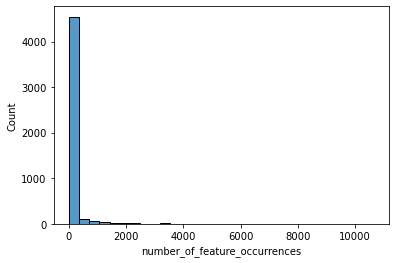

56.79% cech nie występuje w żadnym ze związków.
73.87% cech występuje w mniej niż 0.1% wszystkich związków.
87.33% cech występuje w mniej niż 1.0% wszystkich związków.
96.73% cech występuje w mniej niż 10.0% wszystkich związków.
99.28% cech występuje w mniej niż 50.0% wszystkich związków.




Analiza 3 pliku z fingerprintami (ready_sets/cardiotoxicity_hERG_MACCSFP.csv)
Wejściowe dane:


,IC50,MACCSFP1,MACCSFP2,MACCSFP3,MACCSFP4,MACCSFP5,MACCSFP6,MACCSFP7,MACCSFP8,MACCSFP9,...,MACCSFP157,MACCSFP158,MACCSFP159,MACCSFP160,MACCSFP161,MACCSFP162,MACCSFP163,MACCSFP164,MACCSFP165,MACCSFP166
0,645.0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,0
1,6600.0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,1600.0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,6700.0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,6600.0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11499,6600.0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
11500,100000.0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
11501,30000.0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,1,1,0
11502,26000.0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0



Mamy 11504 wierszy oraz 167 kolumn.
Wszystkie dane są kodowane jako wartości binarne, zapisane jako int64. Jedynie wartość którą przewidujemy - IC50 jest w formacie object.

Ilość wartości nullowych w całym pliku: 0
Dane binarne są prawidołe, jednak wartości IC50 w niektórych przypadkach są niewłaściwe.

Przykładowe niepoprawne wartości:


15                   '='
16                   '='
29                   '='
30       27}]TRIACONTA-8
43                   '='
              ...       
11421                '='
11454                '='
11480                '='
11482                '>'
11483                '>'
Name: IC50, Length: 869, dtype: object

W całym pliku mamy 869 niepoprawnych wartości, co stanowi 7.55% z wszystkich wartości.

Po usunięciu nieprawidłowych wartości mamy 10635 wierszy oraz 167 kolumn.

Każda z kolumn koduje występowanie danej cechy w związku. Zobaczmy w ilu związkach występują poszczególne cechy. (Ponieważ kodowanych cech jest bardzo dużo, skupiłem się na ogólnych statystykach, a nie poszczególnych wartościach.)


,number_of_feature_occurrences
MACCSFP1,0
MACCSFP2,0
MACCSFP3,0
MACCSFP4,0
MACCSFP5,0
...,...
MACCSFP162,10116
MACCSFP163,10619
MACCSFP164,9739
MACCSFP165,10634



Suma wystąpień wszystkich cech we wszystkich związkach: 631831


,number_of_feature_occurrences
count,166.000000
mean,3806.210843
std,3483.025795
min,0.000000
25%,753.250000
50%,2708.000000
75%,6921.500000
max,10635.000000



Histogram przedstawiający w ilu związkach występuje dana cecha:


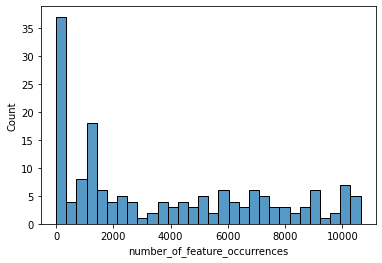

8.43% cech nie występuje w żadnym ze związków.
11.45% cech występuje w mniej niż 0.1% wszystkich związków.
17.47% cech występuje w mniej niż 1.0% wszystkich związków.
29.52% cech występuje w mniej niż 10.0% wszystkich związków.
65.06% cech występuje w mniej niż 50.0% wszystkich związków.




Zobaczmy jeszcze jak wyglądają wartości w kolumnie IC50 (nasz target). Z wcześniejszej analizy widzmy, że kolumna IC50 jest identyczna we wszystkich plikach, więc nie powtarzałem już tego kroku dla każdego z plików osobno.


,IC50
count,10635.00000
mean,318224.83166
std,14001371.69064
min,0.00000
25%,2030.00000
50%,10000.00000
75%,30000.00000
max,1000000000.00000



Zobaczmy jak wartości IC50 rozkładają się na histogramie


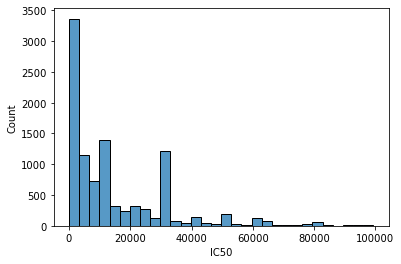

Liczba wartości IC50 mniejszych niż 1: 30
Liczba wartości IC50 większych niż 100 000: 209

Na koniec zobaczmy ile związków zostałoby zaklasyfikowane jako toksyczne w zależności od wartości progu IC50 jaki ustawimy.

Procent związków kardiotoksycznych dla progu IC50 o wartości: 10


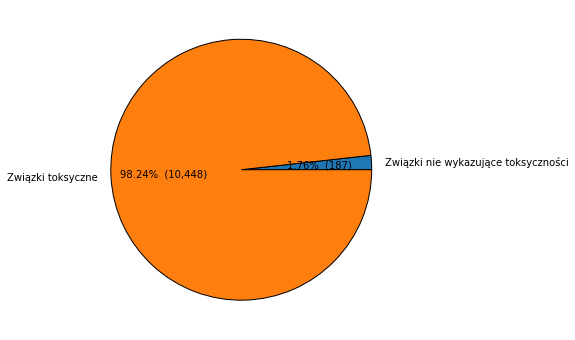

Procent związków kardiotoksycznych dla progu IC50 o wartości: 100


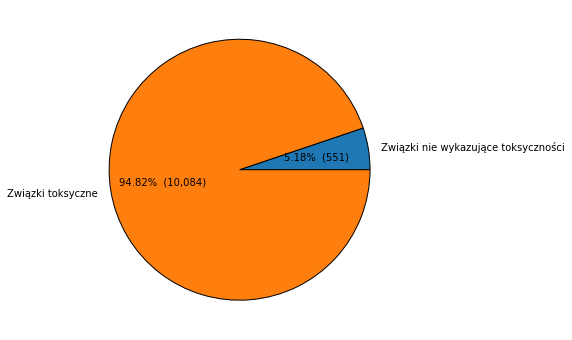

Procent związków kardiotoksycznych dla progu IC50 o wartości: 1000


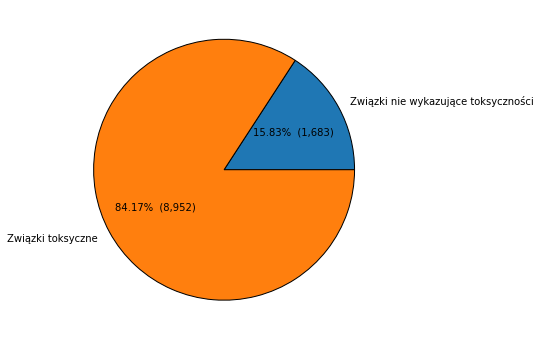

Procent związków kardiotoksycznych dla progu IC50 o wartości: 10000


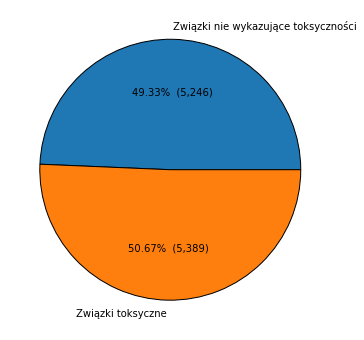

Procent związków kardiotoksycznych dla progu IC50 o wartości: 100000


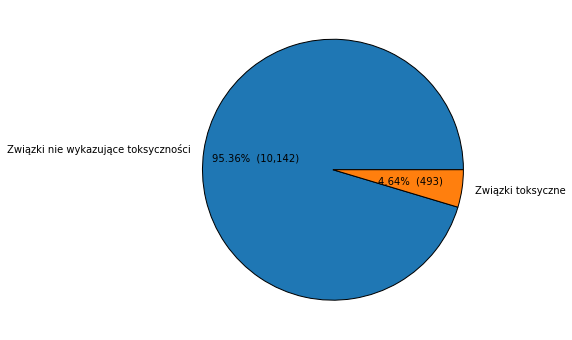

In [8]:
print('W przypadku wszystkich plików w pierwszej kolumnie mamy wartość IC50 która ma związek z kardiotoksycznością. Jest to wartość ciągła, którą będziemy przewidywać. Pozostałe kolumny to fingerprinty które w zależności od typu kodują nieco inne informacje. W ogólności jednak są to wartości binarne informujące czy związke ma daną cechę.')
print()

for i, file in enumerate(cardiotoxicity_files):
    df = pd.read_csv(file, low_memory=False)
    print(f"Analiza {i+1} pliku z fingerprintami ({file})")
    fingerprints_analysis(df)
    
target_analysis(df)

# Wnioski
- Wszystkie pliki mają w zasadzie identyczną strukturę, zmienia się tylko liczba kolumn z fingerprintami.
- W fingerprintach nie ma brakujących/nullowych/niepoprawnych wartości.
- W kolumnie IC50 mała część z wartości jest niepoprawna, jednak w każdym z plików są to te same wartości,
  więc usunięcie ich nie powinno być trudne. W póżniejszym czasie umożliwi nam to też łatwe łączenie danych z kilku plików. 
- Niektóre z cech występują w bardzo małej ilości związków. Widać to zwłaszcza w drugim (największym) pliku, który ma 4860 dostępnych cech, jednak ponad połowa z nich nie występuje w żadnym z dostępnych związków. Pozostałe pliki są pod tym kątem bardziej zbalansowane, jednak prawdopodobnie dobrze by było z każdego z nich usunąć część cech, które pojawiają się najrzadziej.
- Wartości z kolumny IC50 przypominają rozkład wykładniczy, mamy dużo wartości małych i coraz mniej większych. Rozrzut wartości jest jednak bardzo duży - od 0 do 10^9. Myślę, że pomocne będzie usunięcie częsci wartości skrajnych oraz przeniesienie pozostałych do skali logarytmicznej.
- Jeżeli chodzi o klasyfikacje, to fajnym progiem z punktu widzenia modelu wydaje się IC50 = 10 000, który dzieli zbiór na równe części, nie wiem jednak czy ma on jakieś podstawy biologiczne. Postaram się dowiedzieć więcej w późniejszym czasie, na razie i tak zacznę od regresji. 

Na koniec przeprowadziłem jeszcze PCA na zbiorze fingerprintów z trzech plików, jako wstępne podejście do wyboru cech w największym stopniu odpowiedzailnych za kardiotoksyczność.

In [7]:
df_mixed = utils.get_mixed_fingerprints(min_perc_used=0)
X = df_mixed.drop('IC50', axis=1)
X.shape

Preparing files for mixed fingerprints.

Preparing (ready_sets/cardiotoxicity_hERG_MACCSFP.csv) file.
DataFrame base shape: (11504, 167)
Shape after removing wrong values: (10635, 167)
Shape after removing outliers: (10396, 167)

Preparing (ready_sets/cardiotoxicity_hERG_KlekFP.csv) file.
DataFrame base shape: (11504, 4861)
Shape after removing wrong values: (10635, 4861)
Shape after removing outliers: (10396, 4861)

Preparing (ready_sets/cardiotoxicity_hERG_ExtFP.csv) file.
DataFrame base shape: (11504, 1025)
Shape after removing wrong values: (10635, 1025)
Shape after removing outliers: (10396, 1025)



(10396, 6050)

In [14]:
pca = PCA(n_components=1000)
pca.fit(X)

PCA(n_components=1000)

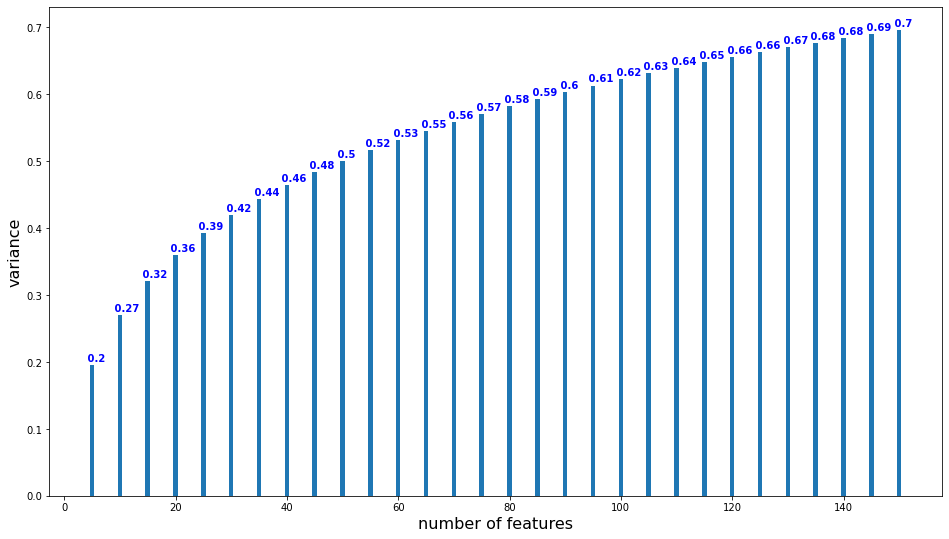

In [12]:
features = list(range(5, 151, 5))
variance = [ pca.explained_variance_ratio_[:feature+1].sum() for feature in features]

fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(features, variance)
plt.xlabel('number of features', fontsize=16)
plt.ylabel('variance', fontsize=16)

for i, v in enumerate(variance):
    ax.text(features[i]-1.5, v+0.01, " "+str(round(v, 2)), color='blue', va='center', fontweight='bold')    
plt.show()

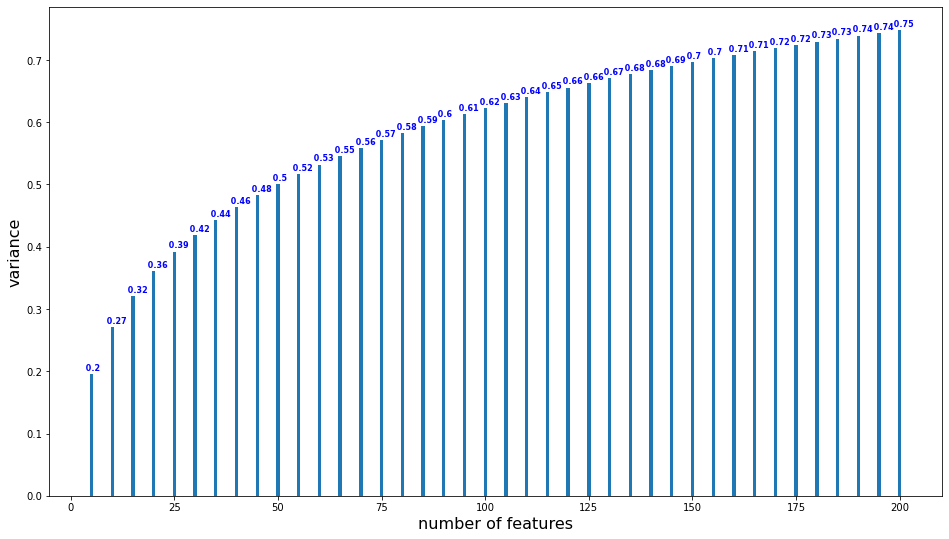

In [33]:
features = list(range(5, 201, 5))
variance = [ pca.explained_variance_ratio_[:feature+1].sum() for feature in features]

fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(features, variance)
plt.xlabel('number of features', fontsize=16)
plt.ylabel('variance', fontsize=16)

for i, v in enumerate(variance):
    ax.text(features[i]-2, v+0.01, " "+str(round(v, 2)), color='blue', va='center', size=8, fontweight='bold')    
plt.show()